# Art Creation using Neural Style Transfer

Neural Style Transfer was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

I will Implement the neural style transfer algorithm to Generate novel artistic images 



In [107]:
import os
import sys
import imageio
import scipy
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint

%matplotlib inline

All libraries loaded

In [108]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'images/style3.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content2.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'

CONFIG class defines constant variables needed for execution. Easy to change as well.

In [109]:

def load_vgg_model(path):
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph



This function returns a model for the purpose of 'painting' the picture.

Takes only the convolution layer weights and wrap using the TensorFlow
Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
the paper indicates that using AveragePooling yields better results.

The last few fully connected layers are not used.

The layer information is stored in a dictionary called vgg_layers. 
Then, we map the weights in the dictionary into a CNN network with the use of helper functions. 

## Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 


## Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [144]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool_10:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_11:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_12:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_13:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_14:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu_32:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_33:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_34:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_35:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_36:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_37:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_38:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_39:0' shape=(

The model is stored in a python dictionary where each variable name is the key and the corresponding value is a tensor containing that variable's value. To run an image through this network, you just have to feed the image to the model. In TensorFlow, you can do so using the [tf.assign](https://www.tensorflow.org/api_docs/python/tf/assign) function. In particular, you will use the assign function like this:  
```python
model["input"].assign(image)
```
This assigns the image as an input to the model. After this, if you want to access the activations of a particular layer, say layer `4_2` when the network is run on this image, you would run a TensorFlow session on the correct tensor `conv4_2`, as follows:  
```python
sess.run(model["conv4_2"])
```

## Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

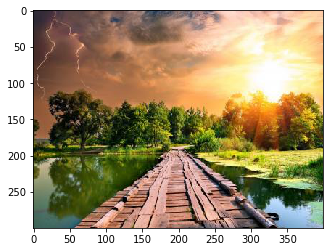

In [111]:
content_image = imageio.imread("images/content2.jpg")
imshow(content_image)

The content image (C) shows a forest surrounded by grass,lake and a bridge, against a sunny sky with a few clouds.


The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the deeper layers tend to detect higher-level features such as more complex textures as well as object classes. 

We would like the "generated" image G to have similar content as the input image C. We need to choose some layer's activations to represent the content of an image. In practice, most visually pleasing results is in the middle of the network--neither too shallow nor too deep
So, suppose we have picked one particular hidden layer to use. Now, let us set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $$a^{(G)}$$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below. 



In [143]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = (tf.reshape(a_C, shape=[n_H*n_W,n_C]))
    a_G_unrolled = (tf.reshape(a_G, shape=[n_H*n_W,n_C]))
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_G_unrolled,a_C_unrolled)))
    return J_content

### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

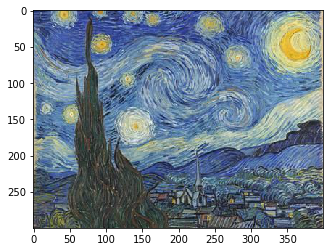

In [113]:
style_image = imageio.imread("images/style3.jpg")
imshow(style_image)

This painting was painted in the style of *[impressionism](https://en.wikipedia.org/wiki/Impressionism)*.

Lets see how you can now define a "style" const function $J_{style}(S,G)$. 

### 3.2.1 - Style matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context. 

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:


The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image. 


In [114]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A,A,transpose_b=True)    
    return GA

### 3.2.2 - Style cost

After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


In [115]:

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(tf.transpose(a_S,[0,3,1,2]),[m,n_C,n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G,[0,3,1,2]),[m,n_C,n_H*n_W])

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.squared_difference(GS,GG))/(4*(n_C**2)*((n_H*n_W)**2))    
    return J_style_layer

###  Style Weights

So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers. After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$. But for now, this is a pretty reasonable default: 

In [116]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


1. Loop over (layer_name, coeff) from STYLE_LAYERS:
        a. Select the output tensor of the current layer. As an example, to call the tensor from the "conv1_1" layer you would do: out = model["conv1_1"]
        b. Get the style of the style image from the current layer by running the session on the tensor "out"
        c. Get a tensor representing the style of the generated image from the current layer. It is just "out".
        d. Now that you have both styles. Use the function you've implemented above to compute the style_cost for the current layer
        e. Add (style_cost x coeff) of the current layer to overall style cost (J_style)
2. Return J_style, which should now be the sum of the (style_cost x coeff) for each layer.


In [117]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]

        a_S = sess.run(out)
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

**Note**: In the inner-loop of the for-loop above, `a_G` is a tensor and hasn't been evaluated yet. It will be evaluated and updated at each iteration when we run the TensorFlow graph in model_nn() below.

How do you choose the coefficients for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, initialize larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, choosing smaller weights for deeper layers and larger weights for the first layers might work better.

<font color='blue'>
    
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. However, we get even better results combining this representation from multiple different layers. This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
    
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 



### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$



In [118]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

In [139]:
def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imwrite(path, image)

save_image helps us to save the image in the correct path

## 4 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:
<font color='purple'>

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG16 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

</font>


We'll now set up TensorFlow to optimize this with respect to $G$. To do so, the program has to reset the graph and use an "[Interactive Session](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)". Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph.  This allows to run variables without constantly needing to refer to the session object, which simplifies the code.  

Lets start the interactive session.

In [120]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

In [121]:
def reshape_and_normalize_image(image):
    
    image = np.reshape(image, ((1,) + image.shape))
    
    image = image - CONFIG.MEANS
    
    return image

reshape_and_normalize_image reshapes image to the shape of (1, height,width, channels). And then subtract the image vector by its mean to match the expected input of VGG.

In [122]:
content_image = imageio.imread("images/content2.jpg")
content_image = reshape_and_normalize_image(content_image)
content_image.shape

(1, 300, 400, 3)

Let's load, reshape and normalize our "style" image (Van Gogh's painting):

In [123]:
style_image = imageio.imread("images/style3.jpg")
style_image = reshape_and_normalize_image(style_image)
style_image.shape

(1, 300, 400, 3)

In [124]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image


Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


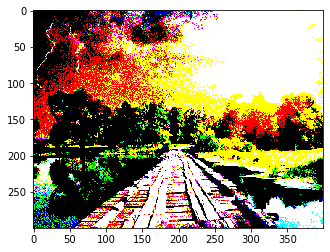

In [125]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

Next, as explained in part (2), let's load the VGG16 model.

In [126]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

In [127]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)
# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out
# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [128]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [132]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(0.1)

# define train_step (1 line)
train_step = optimizer.minimize(J)

This function implements the model_nn() function which initializes the variables of the tensorflow graph, assigns the input image (initial generated image) as the input of the VGG16 model and runs the train_step for a large number of steps.

In [133]:
def model_nn(sess, input_image, num_iterations=10000):
    sess.run(tf.global_variables_initializer())

    sess.run(model['input'].assign(input_image))

    for i in range(num_iterations):

        somthing = sess.run(train_step)
        generated_image = sess.run(model['input'])
        if i % 20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))

            save_image("output/" + str(i) + ".png", generated_image)

    save_image('output/generated_image.jpg', generated_image)

    return generated_image

Lets build the model

In [134]:
K = model_nn(sess, generated_image)

Iteration 0 :
total cost = 4555647500.0
content cost = 11125.737
style cost = 113888420.0
Iteration 20 :
total cost = 3622030000.0
content cost = 10907.915
style cost = 90548024.0
Iteration 40 :
total cost = 2826708700.0
content cost = 11913.467
style cost = 70664744.0
Iteration 60 :
total cost = 2282211600.0
content cost = 12801.981
style cost = 57052090.0
Iteration 80 :
total cost = 1885555700.0
content cost = 13425.537
style cost = 47135536.0
Iteration 100 :
total cost = 1576354600.0
content cost = 13953.768
style cost = 39405376.0
Iteration 120 :
total cost = 1332355500.0
content cost = 14464.448
style cost = 33305270.0
Iteration 140 :
total cost = 1140381200.0
content cost = 14929.547
style cost = 28505800.0
Iteration 160 :
total cost = 988906700.0
content cost = 15348.553
style cost = 24718830.0
Iteration 180 :
total cost = 868397600.0
content cost = 15717.371
style cost = 21706010.0
Iteration 200 :
total cost = 771285100.0
content cost = 16033.224
style cost = 19278120.0
Iterati

Iteration 1860 :
total cost = 40406130.0
content cost = 21134.338
style cost = 1004869.6
Iteration 1880 :
total cost = 39677004.0
content cost = 21165.088
style cost = 986633.8
Iteration 1900 :
total cost = 38964556.0
content cost = 21195.342
style cost = 968815.1
Iteration 1920 :
total cost = 38268468.0
content cost = 21225.168
style cost = 951405.4
Iteration 1940 :
total cost = 37588964.0
content cost = 21255.06
style cost = 934410.3
Iteration 1960 :
total cost = 36925572.0
content cost = 21285.277
style cost = 917818.0
Iteration 1980 :
total cost = 36276412.0
content cost = 21315.56
style cost = 901581.44
Iteration 2000 :
total cost = 35640984.0
content cost = 21345.615
style cost = 885688.2
Iteration 2020 :
total cost = 35019284.0
content cost = 21375.443
style cost = 870138.25
Iteration 2040 :
total cost = 34411516.0
content cost = 21404.887
style cost = 854936.7
Iteration 2060 :
total cost = 33816200.0
content cost = 21434.387
style cost = 840046.4
Iteration 2080 :
total cost = 3

Iteration 3720 :
total cost = 9172824.0
content cost = 23343.863
style cost = 223484.62
Iteration 3740 :
total cost = 9053224.0
content cost = 23361.545
style cost = 220490.22
Iteration 3760 :
total cost = 8936030.0
content cost = 23378.95
style cost = 217556.0
Iteration 3780 :
total cost = 8821249.0
content cost = 23396.014
style cost = 214682.23
Iteration 3800 :
total cost = 8708774.0
content cost = 23413.014
style cost = 211866.1
Iteration 3820 :
total cost = 8598459.0
content cost = 23429.885
style cost = 209104.02
Iteration 3840 :
total cost = 8490254.0
content cost = 23446.46
style cost = 206394.73
Iteration 3860 :
total cost = 8384142.0
content cost = 23462.984
style cost = 203737.8
Iteration 3880 :
total cost = 8280153.5
content cost = 23479.36
style cost = 201134.0
Iteration 3900 :
total cost = 8178081.0
content cost = 23495.62
style cost = 198578.12
Iteration 3920 :
total cost = 8077994.5
content cost = 23511.773
style cost = 196071.92
Iteration 3940 :
total cost = 7979789.5


Iteration 5600 :
total cost = 3747150.5
content cost = 24515.287
style cost = 87549.94
Iteration 5620 :
total cost = 3721280.8
content cost = 24525.016
style cost = 86900.766
Iteration 5640 :
total cost = 3695653.8
content cost = 24534.773
style cost = 86257.65
Iteration 5660 :
total cost = 3670259.8
content cost = 24544.621
style cost = 85620.336
Iteration 5680 :
total cost = 3645235.0
content cost = 24554.365
style cost = 84992.28
Iteration 5700 :
total cost = 3620547.5
content cost = 24564.203
style cost = 84372.64
Iteration 5720 :
total cost = 3596124.5
content cost = 24573.887
style cost = 83759.64
Iteration 5740 :
total cost = 3571981.5
content cost = 24583.438
style cost = 83153.68
Iteration 5760 :
total cost = 3548103.5
content cost = 24592.887
style cost = 82554.36
Iteration 5780 :
total cost = 3524505.0
content cost = 24602.441
style cost = 81962.016
Iteration 5800 :
total cost = 3501206.2
content cost = 24612.03
style cost = 81377.15
Iteration 5820 :
total cost = 3478244.2
c

Iteration 7480 :
total cost = 2177751.5
content cost = 25325.453
style cost = 48112.42
Iteration 7500 :
total cost = 2167071.0
content cost = 25333.414
style cost = 47843.418
Iteration 7520 :
total cost = 2156509.2
content cost = 25341.45
style cost = 47577.367
Iteration 7540 :
total cost = 2146051.5
content cost = 25349.648
style cost = 47313.88
Iteration 7560 :
total cost = 2135700.8
content cost = 25357.64
style cost = 47053.105
Iteration 7580 :
total cost = 2125426.0
content cost = 25365.527
style cost = 46794.266
Iteration 7600 :
total cost = 2115236.8
content cost = 25373.371
style cost = 46537.574
Iteration 7620 :
total cost = 2105121.2
content cost = 25381.246
style cost = 46282.723
Iteration 7640 :
total cost = 2095126.8
content cost = 25388.953
style cost = 46030.93
Iteration 7660 :
total cost = 2085231.9
content cost = 25396.795
style cost = 45781.598
Iteration 7680 :
total cost = 2075431.0
content cost = 25404.525
style cost = 45534.645
Iteration 7700 :
total cost = 2065701

Iteration 9360 :
total cost = 1457722.2
content cost = 25992.318
style cost = 29944.977
Iteration 9380 :
total cost = 1452381.5
content cost = 25999.486
style cost = 29809.666
Iteration 9400 :
total cost = 1447307.8
content cost = 26004.818
style cost = 29681.488
Iteration 9420 :
total cost = 1442587.4
content cost = 26007.658
style cost = 29562.77
Iteration 9440 :
total cost = 1437622.0
content cost = 26016.414
style cost = 29436.447
Iteration 9460 :
total cost = 1432439.0
content cost = 26019.006
style cost = 29306.22
Iteration 9480 :
total cost = 1427151.1
content cost = 26026.0
style cost = 29172.28
Iteration 9500 :
total cost = 1424771.2
content cost = 26028.332
style cost = 29112.197
Iteration 9520 :
total cost = 1417462.0
content cost = 26037.254
style cost = 28927.238
Iteration 9540 :
total cost = 1412835.6
content cost = 26044.205
style cost = 28809.84
Iteration 9560 :
total cost = 1407888.2
content cost = 26049.52
style cost = 28684.824
Iteration 9580 :
total cost = 1405333.1

Let us see how training the model has had an impact on the overall cost,

Iteration 0 :

total cost = 4,555,647,500

content cost = 11125.737

style cost = 113,888,420



After running the model for ten thousand iterations, we observe significant results


Iteration 9980 :


total cost = 1,314,508.5

content cost = 26172.344

style cost = 26394.629


Style cost has fallen from values in the magnitude of 10^9 to 25,000. And content cost has increased slightly. This is due to the fact that raw image is derived from the content and we embedd style into it later. Hence we try to bring the style cost down, without changing the essential content of the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


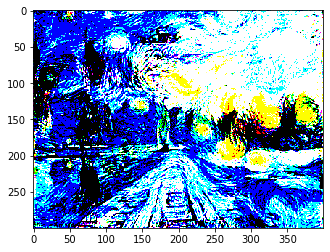

In [140]:
save_image("12" + ".png", K)
imshow(K[0])

The original content image, has been repainted in the image of the Van Gogh's The Starry night.

It took 7 hours to generate this image using the CNN. For this reason, Neural Style transfer is mainly trained using GPUs rather than CPUs

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style The Starry Night(Van Gogh)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/turbo.png" style="width:750px;height:300px;">

## Conclusion

- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
